# Markov Drip Process

## Initial setup

In [117]:
import numpy as np
import math
import matplotlib.pyplot as plt

## Poisson distribution

### Create handling class

In [119]:
class Poisson:
    
    def __init__(self, lam):
        self.lam = lam
        
    def cdf(self, t):
        return 1.0 - np.exp(-self.lam*t)
    
    def inv_cdf(self, F):
        return -(1.0/self.lam)*np.log(1.0 - F)
        
    def times(self, n=1, t_max=np.inf):
        """Returns inter-event interval times sampled from Poisson distribution."""
        F = np.random.uniform(size=n)
        t = self.inv_cdf(F)
        t[t > t_max] = t_max
        return t
    
    def events(self, s):
        """Returns number of events N(s) in interval [0, s) sampled from Poisson distribution."""
        # Guess number of events as Poisson mean
        mean = self.lam*s
        chunk = max(int(mean), 1)
        T = np.cumsum(self.times(chunk))
        idx = np.searchsorted(T, s, side='left')
        n = idx
        
        # Continue sampling time until time s reached
        while (idx == T.size):
            T = np.cumsum(self.times(chunk)) + T[-1]
            idx = np.searchsorted(T, s, side='left')
            n += idx
        
        return n
    
    def P(self, n, s):
        """Returns probability of N(s) = n""" 
        return np.exp(-self.lam*s)*(np.power(self.lam*s, n))/self._factorial(n)
    
    def _factorial(self, n):
        if isinstance(n, np.ndarray):
            fact = np.zeros(n.size)
            for i, n_i in enumerate(n):
                fact[i] = np.prod(np.arange(max(n_i, 1))+1)
        else:
            fact = np.prod(np.arange(max(n_i, 1))+1)
    
        return fact

### Test inter-event time sampling
This should be drawn from an exponential distribution: $t \sim \lambda e^{-\lambda t}$

Expected mean: 2.00000e+00
Actual mean: 2.03639e+00
Expected std: 2.00000e+00
Actual std: 2.03890e+00


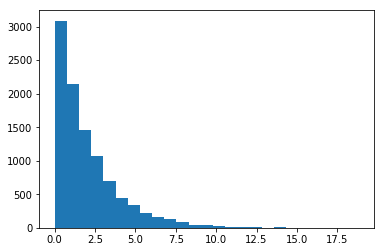

In [107]:
# Settings
lam = 0.5
poisson = Poisson(lam)

# Get inter-event times
sample = poisson.times(10000)

# Print results
print('Expected mean: %.5e' % (1.0/lam))
print('Actual mean: %.5e' % (np.mean(sample)))
print('Expected std: %.5e' % (1.0/lam))
print('Actual std: %.5e' % (np.std(sample)))

# Plot results
plt.hist(sample, bins=25);

### Test event sampling
This should be drawn from the Poisson distribution: $N(s) \sim Poisson(\lambda s)$

Expected mean: 10.00000
Actual mean: 10.15500
Expected std: 3.16228
Actual std: 3.09338


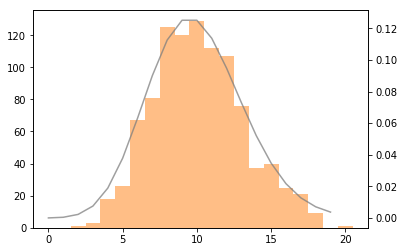

In [110]:
# Settings
lam = 2.0
s = 5.0
iters = 1000

# Create distribution
poisson = Poisson(lam)

# Sample number of events
sample = np.zeros(iters, dtype=np.int64)
for i in range(iters):
    sample[i] = poisson.events(s)
    
# Get probabilities of events samples
n_range = np.arange(2*lam*s)
probs = poisson.P(n=n_range, s=s)

# Print results
print('Expected mean: %.5f' % (lam*s))
print('Actual mean: %.5f' % (np.mean(sample)))
print('Expected std: %.5f' % ((lam*s)**0.5))
print('Actual std: %.5f' % (np.std(sample)))

# Plot results
fig, ax = plt.subplots()
ax.hist(sample, bins=np.arange(np.max(sample))+0.5, color='C1', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(n_range, probs, color='C7', alpha=0.75);

## Patch modeling

### Model single patch

In [140]:
# Settings
lam_drip = 1.0 # initial drip parameter
lam_lick = 1.0/5.0 # lick parameter
lick_timeout = 1.0 # minimum time between rewarded licks
tau = 30.0 # rate of decay of lambda
V_drip = 2.0 # drip volume (uL)
V_reward = 2.0 # reward volume (uL)
t_total = 300 # total seconds to model
t = 0 # current time (s)

# Create initial distribution
mouse = Poisson(lam_lick)
drip = Poisson(lam_drip)
bucket = 0.0 # volume in bucket

# Placeholders (for debugging)
t_drip = [] # drip times
t_lick = [] # lick times
t_event = []
V_bucket = [] # bucket volume

t, t_next_drip, t_next_lick = 0, 0, 0
t_prev_reward = -lick_timeout
while (t <= t_total):
    # Increment timer to next event
    t = min(t_next_drip, t_next_lick)
    
    # Update Poisson params
    drip.lam = lam_0 * np.exp(-t/tau)
    
    # Handle drip event
    if (t == t_next_drip):
        bucket += V_drip
        t_drip.append(t)
        t_next_drip = t + drip.times(t_max=100.0)
    
    # Handle lick event
    if (t == t_next_lick):
        if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
            bucket -= V_reward
            t_prev_reward = t
        t_lick.append(t)
        t_next_lick = t + mouse.times(t_max=100.0)
        
    # Log bucket volume
    t_event.append(t)
    V_bucket.append(bucket)
    
# Create arrays
t_drip = np.array(t_drip)
t_lick = np.array(t_lick)
t_event = np.array(t_event)
V_bucket = np.array(V_bucket)

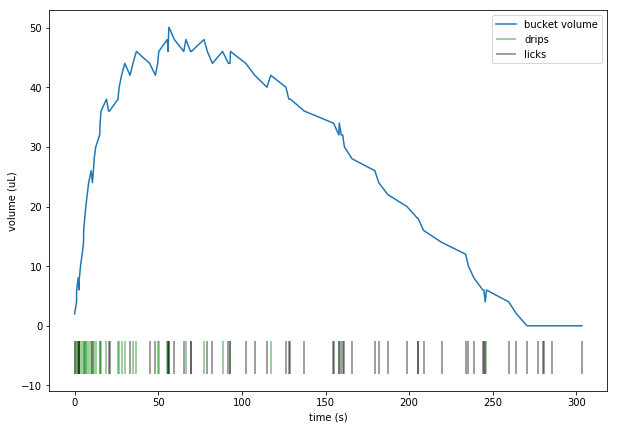

In [141]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

### Search parameter space
It might be best to solve for the optimal foraging behavior (e.g. residence time) given a specified environment (e.g. travel time, cumulative reward function). Here, the cumulative reward function is actually based on a non-homogeneous Poisson process in the drip function.

Recall that a Poisson process is given by:
- exponentially distributed variables $t \st p(t) = \lambda e^{-\lambda t}$
- a random variable $T \st T_n = t_1 + t_2 + \ldots + t_n$
- a number of events $N \st N(s) = max{n | T_n \leq s}$

The underlying statistics of such a process are:

$
\quad P(N(s) = n) = e^{-\lambda s} \frac{(\lambda s)^n}{n!} = Poisson(\lambda s) \\
\quad \mathbb{E}[N(s)] = \lambda s \\
\quad var[N(s)] = \lambda s
$

(We will use $p$ for probability density and $P$ for cumulative probability density. See Appendix for derivation of these statistics.)

When $\lambda$ is constant, the above is termed a *homogeneous* Poisson process. However, if $\lambda$ varies over time, then the process becomes *non-homogeneous* or *inhomogeneous*. In such cases, the process can be modeled as a homogeneous Poisson process over some interval $\left [ t_1, t_2 \right ]$ by replacing $\lambda$ with its integral over that time interval:

$
\quad \Lambda(t, s) = \int_t^{t+s} \lambda(t) dt \\
\quad P_t(N(s) = n) = e^{-\Lambda(t, s)} \frac{(\Lambda(t, s))^n}{n!} = Poisson(\Lambda(t, s)) \\
\quad \mathbb{E}_t[N(s)] = \Lambda(t, s) \\
\quad var_t[N(s)] = \Lambda(t, s)
$

(See Appendix for derivations.)

Given that drip times follow $T \sim Poisson(\lambda(t) s)$, the mean inter-drip time is given by $\mathbb{E}(t_i - t_{i-1}) = \frac{1}{\lambda}$, or the mean drip rate is $\frac{1}{\mathbb{E}(t_i - t_{i-1})} = \lambda$. The fill rate of the bucket is then $\frac{dV}{dt} = \lambda V_{drip}$. By integrating over time, we get the cumulative volume (reward) function:

$\quad V = \int_0^s \lambda V_{drip} dt$

In this case, $\lambda$ decays over time:

$\quad \lambda(t) = \lambda_0 e^{-\frac{t}{\tau}}$

So the cumulative reward functions becomes:

$
\begin{align}
\quad V &= \int_0^s \lambda_0 e^{-\frac{t}{\tau}} V_{drip} dt \\
&= \lambda_0 V_{drip} \int_0^s e^{-\frac{t}{\tau}} dt \\
&= \lambda_0 V_{drip} \tau \left ( 1 - e^{-\frac{s}{\tau}} \right )
\end{align}
$

Looking at the solution to the marginal value theorem for an exponentially decaying reward rate, we see that, on average, the Poisson drip model is in fact equivalent, with $r_0 = \lambda_0 V_{drip}$. Thus searching for parameters in this model amounts to finding the right parameters in the deterministic model ($r_0, R_0, \tau$), and then tuning the Poisson model parameters ($\lambda_0, V_{drip}$) within the constraint that $\lambda_0 V_{drip} = r_0$. While the expected cumulative reward per patch will remain the same, the variance of the cumulative reward per patch will increase as $V_{drip}$ increases. Therefore, after finding the right point in parameter space for the deterministic model, the degree of stochasticity can be tuned by varing $V_{drip}$ (which will also change $\lambda$ due to the aforementioned constraint).

Because we know the variance of a Poisson distribution, we can solve for this explicitly. The number of drips over time in a patch is given by:

$ 
\quad \mathbb{E}[N(s)] = \lambda s \\
\quad var[N(s)] = \lambda s
$

## Appendix

### Homogeneous Poisson process

The mean and variance of a homogeneous Poisson process (that is, $\lambda(t) = k \: \forall \: t$) are given by:

$
\begin{align}
\quad \mathbb{E}[N(s)] 
&= \sum_{n=0}^{\infty} n \cdot P(N(s) = n) \\
&= 0 + \sum_{n=1}^{\infty} n \cdot P(N(s) = n) \\
&= \sum_{n=1}^{\infty} n e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=1}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) \sum_{n=1}^{\infty} \frac{(\lambda s)^{n-1}}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) (e^{\lambda s}) \\
&= \lambda s
\end{align}
$

$
\begin{align}
\quad \mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]
&= \sum_{n=0}^{\infty} n(n-1) \cdot P(N(s) = n) \\
&= 0 + 0 + \sum_{n=2}^{\infty} n(n-1) e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=2}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) \sum_{n=2}^{\infty} \frac{(\lambda s)^{n-2}}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) (e^{\lambda s}) \\
&= (\lambda s)^2
\end{align}
$

$
\begin{align}
\quad var[N(s)]
&= \mathbb{E}[(N(s))^2] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2] - \mathbb{E}[N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2 - N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))(N(s) - 1)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= (\lambda s)^2 + \lambda s - (\lambda s)^2 \\
&= \lambda s
\end{align}
$

where we used the Taylor expansion $e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}$ in the infinite sums.

### Non-homogeneous Poisson process